In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from pingouin import welch_anova, pairwise_tukey
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Resumo

A seguradora para a qual você está trabalhando recentemente coletou um conjunto de dados de seus clientes que inclui informações como idade, sexo, índice de massa corporal (IMC), número de dependentes, hábito de fumar e região de residência. Com base nesses dados, a seguradora deseja prever os custos médicos futuros de seus clientes para melhorar suas estimativas financeiras e otimizar suas políticas de cobertura.
- Como cientista de dados da equipe, seu papel é desenvolver um modelo preditivo para alcançar esse objetivo.

### **Cleaning** and **Modeling**

In [127]:

df = pd.read_csv('../../data/09. TCC/custos/insurance.csv')

## feature engineering
df['fat'] = df['bmi'].apply(lambda x: 'yes' if x > 30 else 'no') 

### **EDA**

In [128]:

print(df.shape)
display(
    pd.DataFrame({
        'Tipo': df.dtypes,
        'Qtde nulos': df.isnull().sum(),
        'Proporção nulos': df.isnull().mean(),
        'Qtde unicos': df.nunique(),
        'Exemplo unicos': df.apply(lambda x: x.unique()[:3])
    })
)

(1338, 8)


,Tipo,Qtde nulos,Proporção nulos,Qtde unicos,Exemplo unicos
age,int64,0,0.0,47,"[19, 18, 28]"
sex,object,0,0.0,2,"[female, male]"
bmi,float64,0,0.0,548,"[27.9, 33.77, 33.0]"
children,int64,0,0.0,6,"[0, 1, 3]"
smoker,object,0,0.0,2,"[yes, no]"
region,object,0,0.0,4,"[southwest, southeast, northwest]"
charges,float64,0,0.0,1337,"[16884.924, 1725.5523, 4449.462]"
fat,object,0,0.0,2,"[no, yes]"


#### **analise univariada**

In [129]:

df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


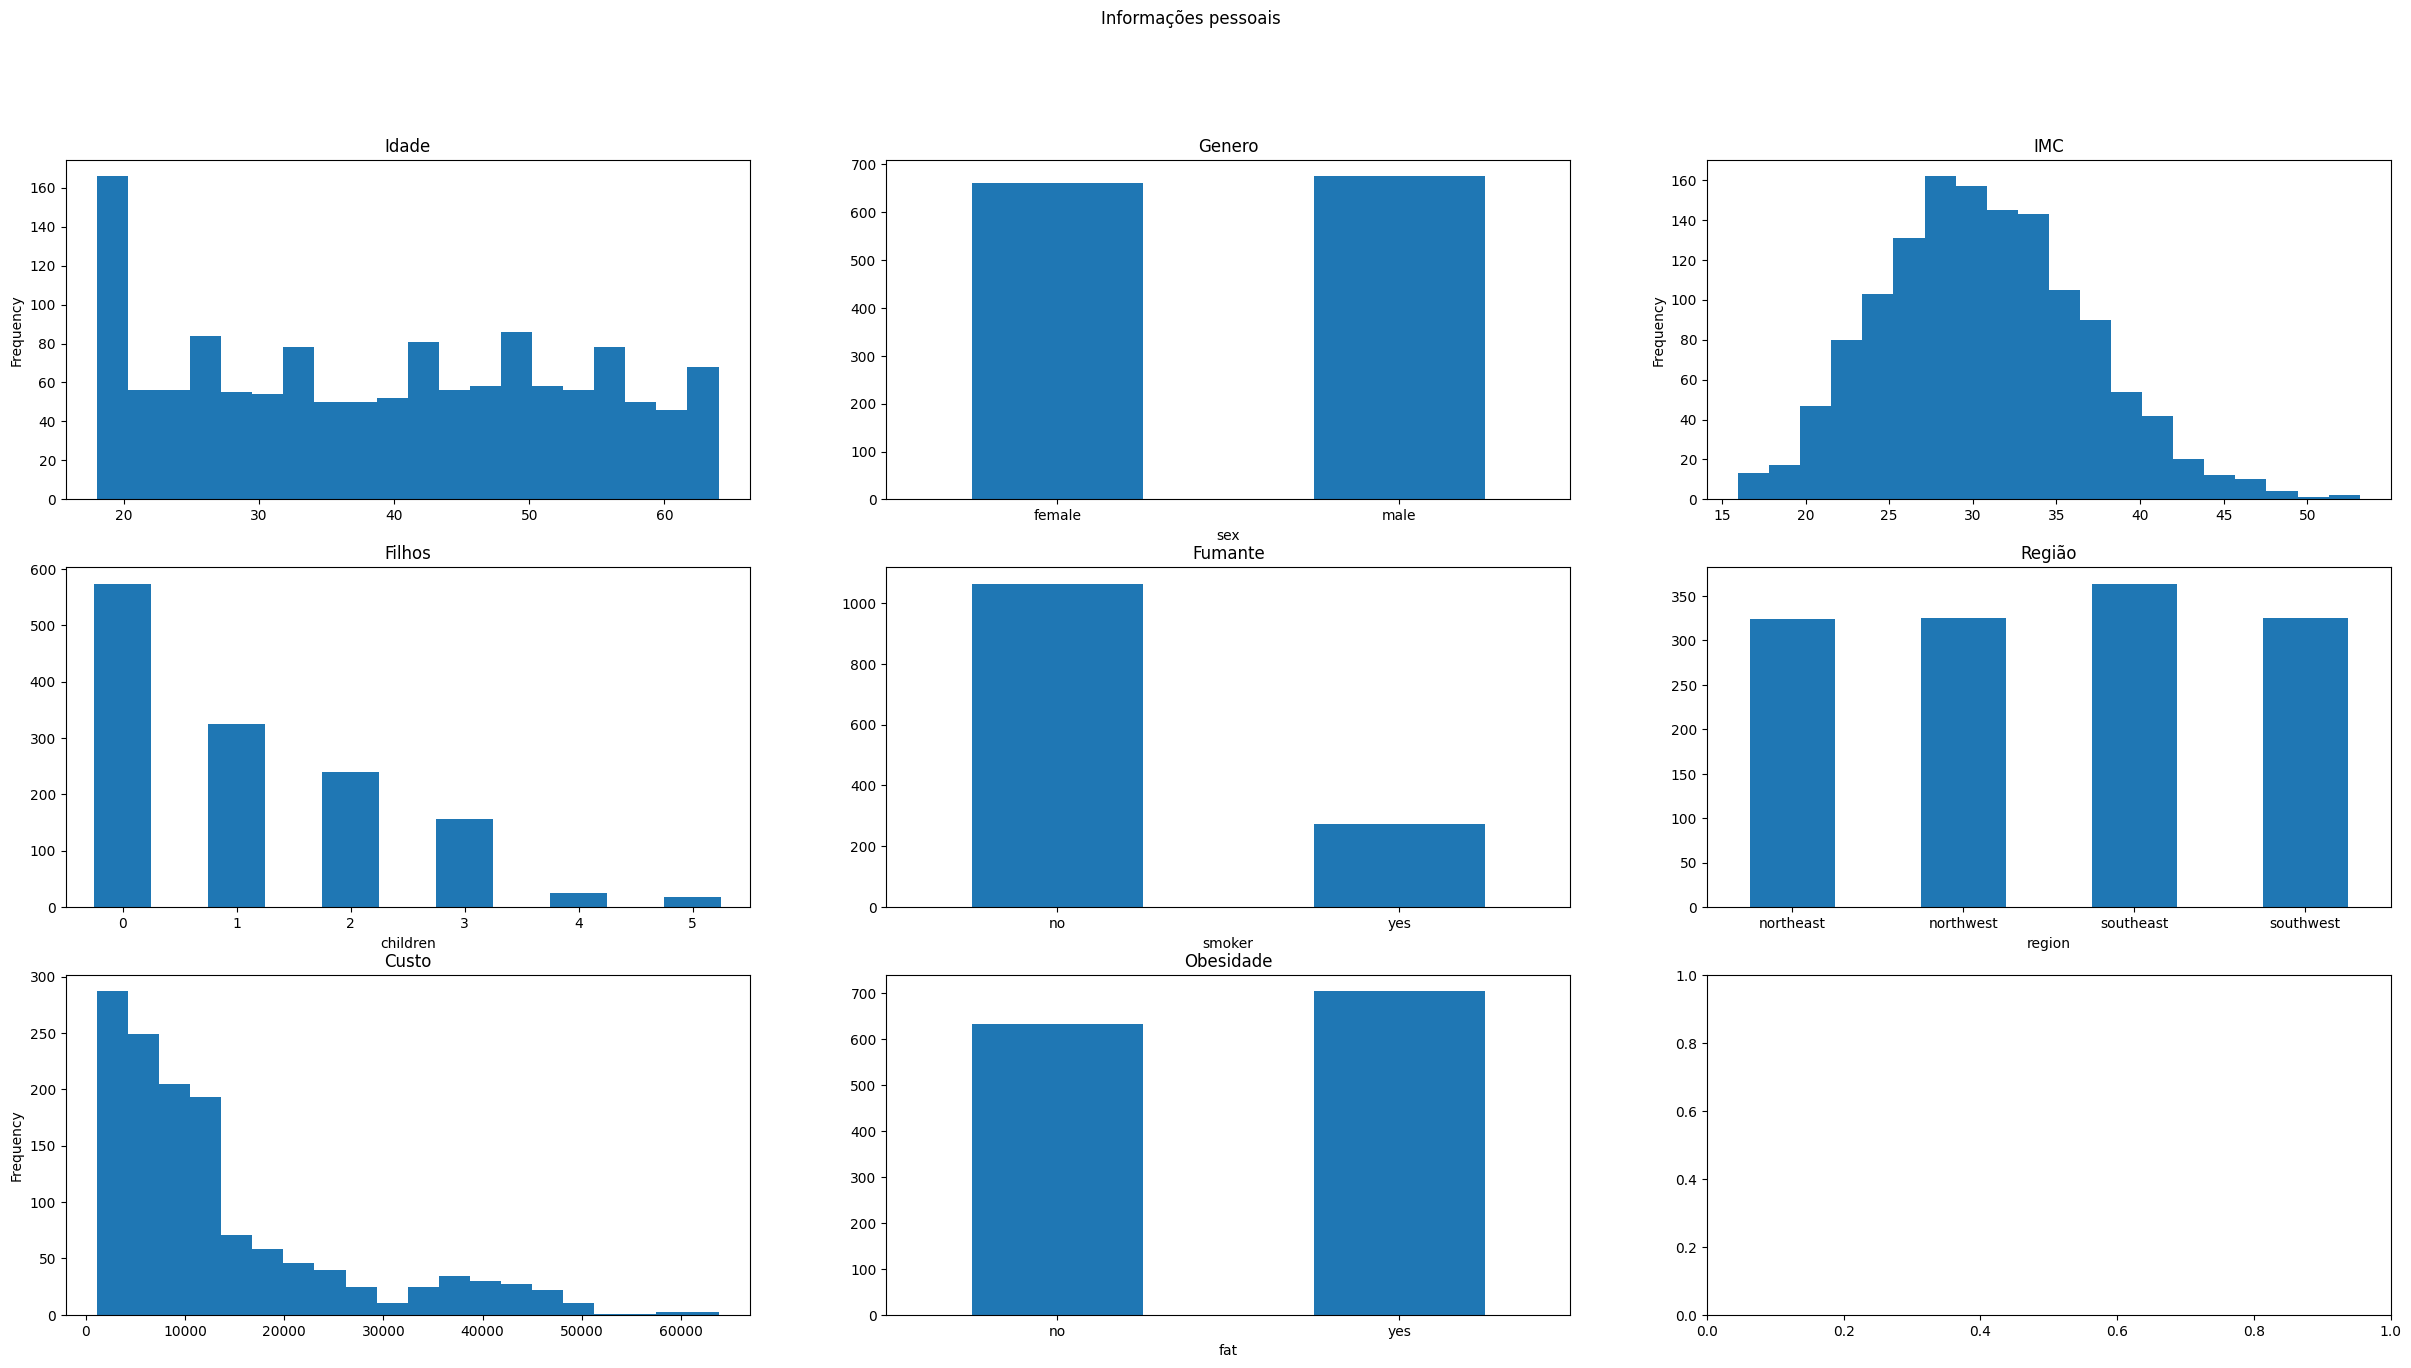

In [130]:

fig, axs = plt.subplots(3, 3, figsize=(30, 15))

df['age'].plot.hist(ax=axs[0, 0], bins=20)
axs[0, 0].set_title('Idade')

df.groupby('sex')['age'].count().plot.bar(ax=axs[0, 1])
axs[0, 1].set_title('Genero')
axs[0, 1].tick_params(axis='x', labelrotation=0)

df['bmi'].plot.hist(ax=axs[0, 2], bins=20)
axs[0, 2].set_title('IMC')

df.groupby('children')['age'].count().plot.bar(ax=axs[1, 0])
axs[1, 0].set_title('Filhos')
axs[1, 0].tick_params(axis='x', labelrotation=0)

df.groupby('smoker')['age'].count().plot.bar(ax=axs[1, 1])
axs[1, 1].set_title('Fumante')
axs[1, 1].tick_params(axis='x', labelrotation=0)

df.groupby('region')['age'].count().plot.bar(ax=axs[1, 2])
axs[1, 2].set_title('Região')
axs[1, 2].tick_params(axis='x', labelrotation=0)

df['charges'].plot.hist(ax=axs[2, 0], bins=20)
axs[2, 0].set_title('Custo')

df.groupby('fat')['age'].count().plot.bar(ax=axs[2, 1])
axs[2, 1].set_title('Obesidade')
axs[2, 1].tick_params(axis='x', labelrotation=0)

plt.suptitle('Informações pessoais')
plt.show()

*insights:* 
- idade: maioria das pessoas possuem pouco menos ou igual a 20 anos, após isso a distribuição é quase uniforme até pouco mais que 60 anos.
- genêro: pessoas bem distribuidas entre feminino e masculino.
- IMC: segue uma distribuição perto de uma normal com média = 30.
- filhos: maioria das pessoas possuem zero filhos e a proporção diminui suavemente até 5 filhos.
- fumante: maioria das pessoas não possuem filhos.
- região: pessoas bem distribuidas entre as regiões.
- custo: maioria das pessoas possuem baixo custo e a proporção diminui suavemente até 10k+ até cair abruptamente e depois diminir suavemente até 60k+.
- obesidade: pessoas bem distribuidas entre obeso e não obeso.

#### **analise bivariada** - versus charges

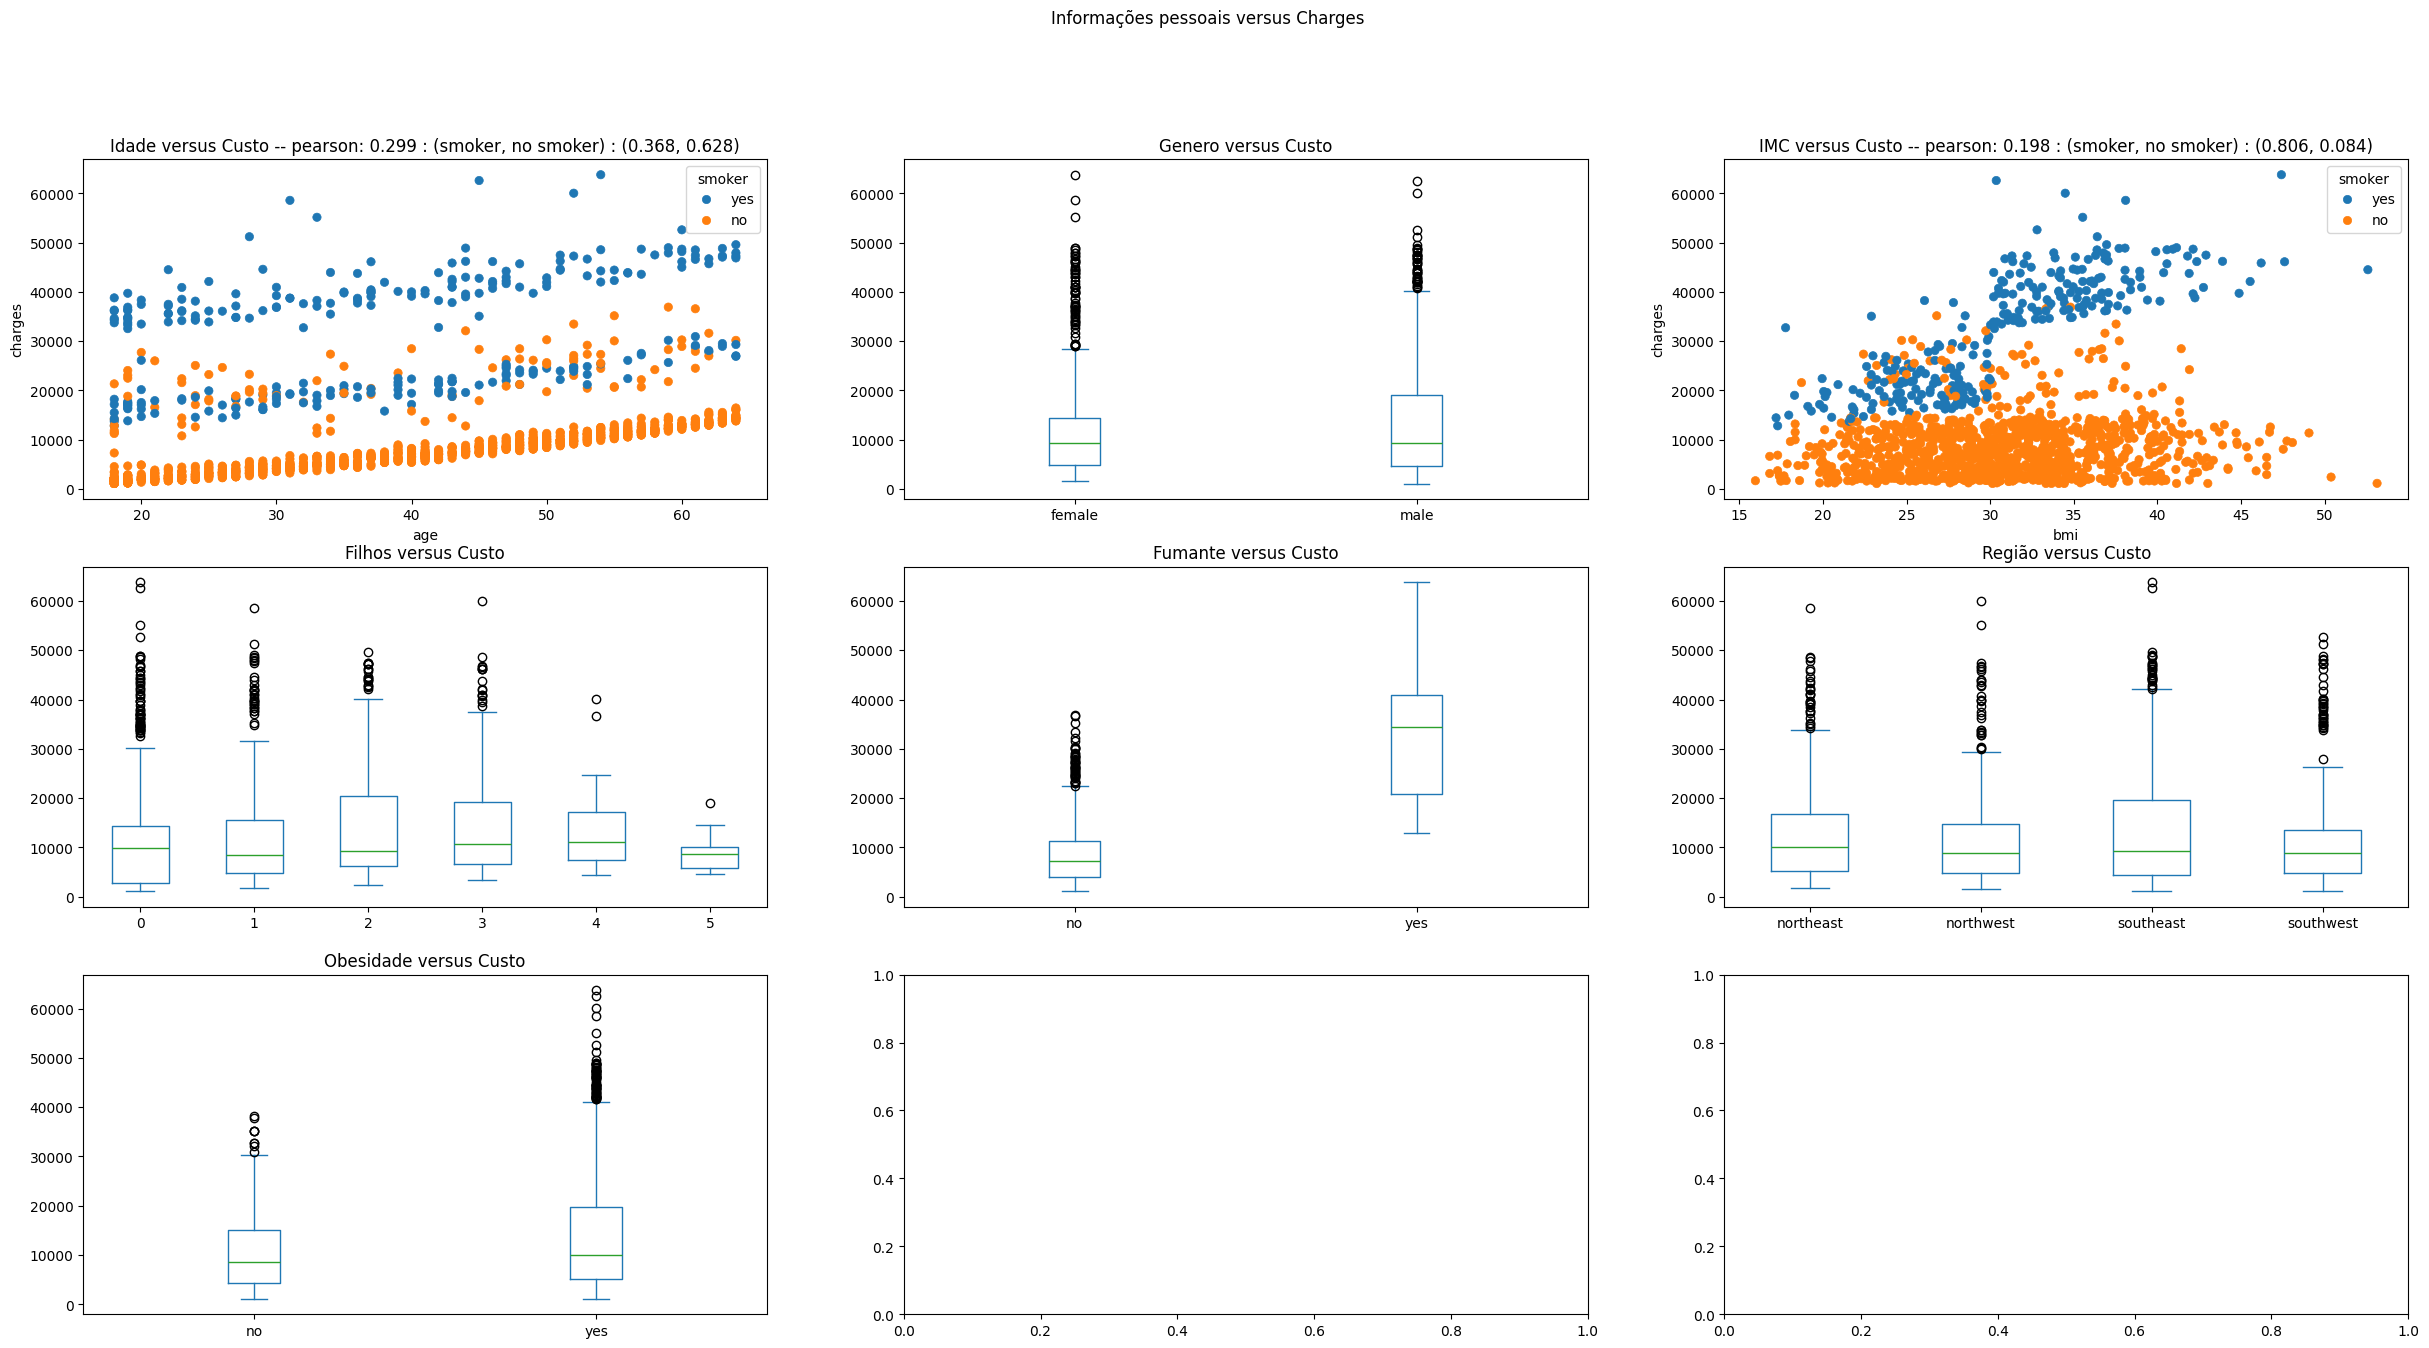

In [131]:

fig, axs = plt.subplots(3, 3, figsize=(30, 15))

sns.scatterplot(x='age', y='charges', data=df, hue='smoker', ec=None, ax=axs[0, 0])
corr = float(round(df[['age','charges']].corr().values[0, 1], 3))
smoker_corr = float(round(df[df['smoker'] == 'yes'][['age','charges']].corr().values[0, 1], 3))
no_smoker_corr = float(round(df[df['smoker'] == 'no'][['age','charges']].corr().values[0, 1], 3))
axs[0, 0].set_title(f"Idade versus Custo -- pearson: {corr} : (smoker, no smoker) : ({smoker_corr}, {no_smoker_corr})")

df[['sex','charges']].plot.box(by='sex', ax=axs[0, 1])
# sns.boxplot(data=df, x='sex', y='charges', hue='smoker', ax=axs[0, 1])
axs[0, 1].set_title('Genero versus Custo')
axs[0, 1].tick_params(axis='x', labelrotation=0)

sns.scatterplot(x='bmi', y='charges', data=df, hue='smoker', ec=None, ax=axs[0, 2])
corr = float(round(df[['bmi','charges']].corr().values[0, 1], 3))
smoker_corr = float(round(df[df['smoker'] == 'yes'][['bmi','charges']].corr().values[0, 1], 3))
no_smoker_corr = float(round(df[df['smoker'] == 'no'][['bmi','charges']].corr().values[0, 1], 3))
axs[0, 2].set_title(f"IMC versus Custo -- pearson: {corr} : (smoker, no smoker) : ({smoker_corr}, {no_smoker_corr})")

df[['children','charges']].plot.box(by='children', ax=axs[1, 0])
# sns.boxplot(data=df, x='children', y='charges', hue='smoker', ax=axs[1, 0])
axs[1, 0].set_title('Filhos versus Custo')
axs[1, 0].tick_params(axis='x', labelrotation=0)

df[['smoker','charges']].plot.box(by='smoker', ax=axs[1, 1])
axs[1, 1].set_title('Fumante versus Custo')
axs[1, 1].tick_params(axis='x', labelrotation=0)

df[['region','charges']].plot.box(by='region', ax=axs[1, 2])
# sns.boxplot(data=df, x='region', y='charges', hue='smoker', ax=axs[1, 2])
axs[1, 2].set_title('Região versus Custo')
axs[1, 2].tick_params(axis='x', labelrotation=0)

df[['fat','charges']].plot.box(by='fat', ax=axs[2, 0])
# sns.boxplot(data=df, x='fat', y='charges', hue='smoker', ax=axs[2, 0])
axs[2, 0].set_title('Obesidade versus Custo')
axs[2, 0].tick_params(axis='x', labelrotation=0)

plt.suptitle('Informações pessoais versus Charges')
plt.show()

In [132]:

a = .05

print('-- Idade')
print(f"-> correlação entre Idade e Custo: {float(round(df[['age','charges']].corr().values[0, 1], 3))}")
print('** sob implicação de Fumante **')
print(f"-> correlação entre Idade (não fumante) e Custo: {float(round(df[df['smoker'] == 'no'][['age','charges']].corr().values[0, 1], 3))}")
print(f"-> correlação entre Idade (fumante) e Custo: {float(round(df[df['smoker'] == 'yes'][['age','charges']].corr().values[0, 1], 3))}")

print()
print('-- Genero')
display(df.groupby('sex')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['sex']=='female']['charges'].values, 
    df[df['sex']=='male']['charges'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- IMC')
print(f"-> correlação entre Idade e Custo: {float(round(df[['bmi','charges']].corr().values[0, 1], 3))}")
print('** sob implicação de Fumante **')
print(f"-> correlação entre Idade (não fumante) e Custo: {float(round(df[df['smoker'] == 'no'][['bmi','charges']].corr().values[0, 1], 3))}")
print(f"-> correlação entre Idade (fumante) e Custo: {float(round(df[df['smoker'] == 'yes'][['bmi','charges']].corr().values[0, 1], 3))}")

print()
print('-- Filhos')
display(df[['children', 'charges']].groupby('children')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='charges', between='children', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')
# ... já que existe pelo menos 1 média diferente a outras, teste de hipoteses POST-HOC ~ pair wise Tukey entre as médias.
df_pairwise = pairwise_tukey(dv='charges', between='children', data=df)
print('-> médias estatisticamente diferentes:')
display(df_pairwise[df_pairwise['p-tukey'] <= a])

print()
print('-- Fumante')
display(df.groupby('smoker')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['smoker']=='yes']['charges'].values, 
    df[df['smoker']=='no']['charges'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- Região')
display(df[['region', 'charges']].groupby('region')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 3+ médias com var populacional desconhecidas e suspostamente diferentes. ANOVA Welch
p_value = welch_anova(dv='charges', between='region', data=df).values[0, 4] # h0: medias iguais (estatisticamente)
print('->', '' if p_value <= a else 'não', f'existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

print()
print('-- Obesidade')
display(df.groupby('fat')['charges'].mean().sort_values().reset_index(name='MEAN'))
# teste de hipoteses para 2 médias com var populacional desconhecidas e suspostamente diferentes. T-Student Welch
t_stat, p_value = ttest_ind( # h0: m1 = m2 (estatisticamente)
    df[df['fat']=='yes']['charges'].values, 
    df[df['fat']=='yes']['charges'].values, 
    equal_var=False) 
print('->', '' if p_value <= a else 'não', f'existe diferença estatistica entre as médias a um intervalo de confiança de {1-a}.', f'p-value = {p_value}')

-- Idade
-> correlação entre Idade e Custo: 0.299
** sob implicação de Fumante **
-> correlação entre Idade (não fumante) e Custo: 0.628
-> correlação entre Idade (fumante) e Custo: 0.368

-- Genero


,sex,MEAN
0,female,12569.578844
1,male,13956.751178


->  existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 0.03584101495601664

-- IMC
-> correlação entre Idade e Custo: 0.198
** sob implicação de Fumante **
-> correlação entre Idade (não fumante) e Custo: 0.084
-> correlação entre Idade (fumante) e Custo: 0.806

-- Filhos


,children,MEAN
0,5,8786.035247
1,0,12365.975602
2,1,12731.171832
3,4,13850.656311
4,2,15073.563734
5,3,15355.318367


->  existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 1.0507578441888616e-05
-> médias estatisticamente diferentes:


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
1,0,2,12365.975602,15073.563734,-2707.588132,926.910687,-2.921088,0.041294,-0.220191



-- Fumante


,smoker,MEAN
0,no,8434.268298
1,yes,32050.231832


->  existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 5.88946444671698e-103

-- Região


,region,MEAN
0,southwest,12346.937377
1,northwest,12417.575374
2,northeast,13406.384516
3,southeast,14735.411438


-> não existe pelo menos 1 média estatistica diferente a outras a um intervalo de confiança de 0.95. p-value = 0.05059276321931547

-- Obesidade


,fat,MEAN
0,no,10719.386942
1,yes,15560.926321


-> não existe diferença estatistica entre as médias a um intervalo de confiança de 0.95. p-value = 1.0


*insights:*
- idade: não existe uma correlação forte entre Idade e Custo por si só. porem analisando por Fumante descobrimos que Idade+Fumante versus Custo possui uma correlação de Pearson quase forte de .628.
- genero: existe diferença significativa nas médias de Custo por Genero, onde masculino tem uma média maior. analisando por Fumante vemos que a diferença passa a existir.
- IMC: não existe uma correlação forte entre IMC e Custo por si só. porem analisando como Fumante implica tal correlação descobrimos que IMC+Fumante versus Custo possui uma correlação de Pearson forte de .806.
- IMC: para IMC+Fumante é possivel ver uma mudança de comportamento antes e depois do IMC=30. onde IMC > 30 = obesidade. (feature adicionada em **Cleaning** and **Modeling** )
- filhos: existe diferença significativa apenas entre duas médias em Filhos, que é entre 0 Filhos versus 2 Filhos.
- fumante: existe diferença MUITO significativa entre nas médias de Fumante (yes versus no).
- região: não existe diferença significativa entre nas médias para Região. porem a diferença passa a existir quando analisamos Região+Fumante.
- obesidade: não existe diferença significativa nas médias de Custo por Obesidade. analisando por Fumante vemos que a diferença passa a existir.

*pertinente:* Grande chance de a feature Fumante ser a mais impactante contra Custo.

#### **analise multivariada** | Regressão Linear - versus charges

##### modelo A

In [148]:

df_rl = df.copy()

target = 'charges'

print('dummies')
dummies = []
# classic categ dummies
dummies_cols = ['sex','region']
dummies += dummies_cols
default_dimmies_cols = []
for col in dummies_cols:
    print(f"default for {col}: {df_rl[col].unique()[0]}")
    for i, val in enumerate(df_rl[col].unique()):
        col_name = f"{col}_{val.replace(' ','_').replace('-','_')}_"
        df_rl[col_name] = (df_rl[col] == val).astype(int)
        if i == 0: default_dimmies_cols.append(col_name)
    df_rl = df_rl.drop(col, axis=1)
df_rl = df_rl.drop(default_dimmies_cols, axis=1) # deletando colunas redundantes
# yes or no dummies
dummies_cols = ['smoker', 'fat']
dummies += dummies_cols
for col in dummies_cols:
    df_rl[col] = (df_rl[col]=='yes').astype(int)

# feature engineering
#-a)
# poly = PolynomialFeatures(2, interaction_only=False, include_bias=False)
# rl_boosted = poly.fit_transform(df_rl.drop(target, axis=1))
# y = df_rl[target].values

# columns = poly.get_feature_names_out(df_rl.drop(target, axis=1).columns)
# columns = [col.replace(' ','__').replace('^','') for col in columns]

# df_rl_boosted=pd.DataFrame(rl_boosted, columns=columns)
# df_rl_boosted[target] = y

# df_rl = df_rl_boosted.copy()
#-b)
df_rl['smoker_bmi'] = df_rl['smoker']*df['bmi']
df_rl['fat_smoker'] = df_rl['fat']*df_rl['smoker'] ## dummie
boosted_no_dummie_features = ['smoker_bmi']

# target_relat = 'fat'
# for col in [col for col in df_rl.columns if target != col]:
#     col_name_ = f'{col}__{target_relat}'
#     df_rl[col_name_] = df_rl[col]*df_rl[target_relat]

# padronizando valores
# scaler = StandardScaler()
# df_rl_values = scaler.fit_transform(df_rl)
# df_rl = pd.DataFrame(df_rl_values, columns=df_rl.columns)

# train/test split
df_test = df_rl.sample(int(df_rl.shape[0]*.2))
df_rl = df_rl.loc[[i for i in df_rl.index if i not in df_test.index]]
print(f'\ntest: {df_test.shape[0]/(df_test.shape[0]+df_rl.shape[0])}, train: {df_rl.shape[0]/(df_test.shape[0]+df_rl.shape[0])}')

print()
print('random train example:')
display(df_rl.sample().iloc[0])

dummies
default for sex: female
default for region: southwest

test: 0.19955156950672645, train: 0.8004484304932735

random train example:


age                    20.00000
bmi                    32.39500
children                1.00000
smoker                  0.00000
charges              2362.22905
fat                     1.00000
sex_male_               1.00000
region_southeast_       0.00000
region_northwest_       1.00000
region_northeast_       0.00000
smoker_bmi              0.00000
fat_smoker              0.00000
Name: 692, dtype: float64

In [149]:

features = [col for col in df_rl.columns if target not in col]

formula = f"{target} ~ {' + '.join(features)}"
model = smf.ols(formula=formula, data=df_rl)
res = model.fit()
res.summary()

### Omnibus 
# h0: todos os coeficientes (excluindo o interpecto) são iguais a zero, i.e., são insignificantes -> modelo irrelevante.
# ha: pelo menos 1 coeficiente é diferente de zero, i.e., pelo menos 1 coeficiente significante -> modelo não irrelevante.
### Jarque-Bera
# h0: distribuição dos residuos seguem uma normal.
# ha: distribuição dos residuos não seguem uma normal.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     613.5
Date:                Thu, 06 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:22:33   Log-Likelihood:                -10515.
No. Observations:                1071   AIC:                         2.105e+04
Df Residuals:                    1059   BIC:                         2.111e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -3384.0343   1197.511     -2.826      0.005   -5733.798   -1034.270
age                 266.1479      9.750     27.297      0.000     247.016     285.279
bmi                  19.2074     43.069      0.446      0.656     -65.303     103.718
children            525.3353    114.067      4.605      0.000     301.512     749.158
smoker              663.2598   2323.147      0.286      0.775   -3895.234    5221.753
fat                  66.0553    512.091      0.129      0.897    -938.772    1070.883
sex_male_          -567.1424    275.188     -2.061      0.040   -1107.118     -27.167
region_southeast_   251.6734    385.900      0.652      0.514    -505.542    1008.889
region_northwest_   644.2215    394.677      1.632      0.103    -130.216    1418.659
region_northeast_  1188.0884    396.757      2.994      0.003     409.569    1966.608
smoker_bmi          499.8748     89.346      5.595      0.000     324.560     675.190
fat_smoker         1.472e+04   1135.523     12.965      0.000    1.25e+04     1.7e+04
==============================================================================
Omnibus:                      720.169   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5945.820
Skew:                           3.206   Prob(JB):                         0.00
Kurtosis:                      12.598   Cond. No.                         964.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

performance:
train RMSE: 4441.097164322277, MAPE: 0.2642700356894481
test RMSE: 4138.114500153675, MAPE: 0.25414836018184656


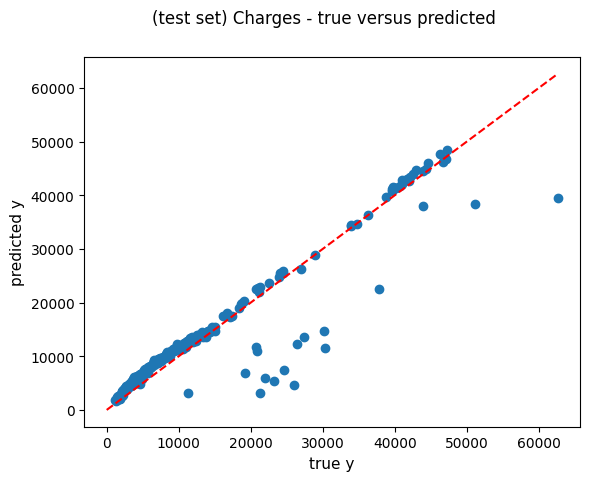

In [150]:

print('performance:')

y_true = df_rl['charges'].values
y_pred = res.predict(df_rl.drop('charges', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
train_rmse = np.sqrt(mse)
train_mape = mean_absolute_percentage_error(y_true, y_pred)

y_true = df_test['charges'].values
y_pred = res.predict(df_test.drop('charges', axis=1)).values

mse = mean_squared_error(y_true, y_pred)
test_rmse = np.sqrt(mse)
test_mape = mean_absolute_percentage_error(y_true, y_pred)

print(f'train RMSE: {train_rmse}, MAPE: {train_mape}')
print(f'test RMSE: {test_rmse}, MAPE: {test_mape}')

plt.scatter(x=y_true, y=y_pred)
plt.plot([0, max(y_true)], [0, max(y_true)], 'r--')

plt.xlabel('true y', fontsize=11)
plt.ylabel('predicted y', fontsize=11)
plt.suptitle('(test set) Charges - true versus predicted')

plt.show()

*insights:* 

<br> **(antes do feature engineering)** *R2: .756*, *test set MAPE: +- .4221*
- como esperado, Fumante é oq mais impacta positivamente o Custo... no caso dos coeficientes acima Não Fumante é oque mais impacta negativamente o modelo, i.e. analogo a afirmação de que Fumante é oq mais impacta positivamente o Custo. 
- como visto em analise bivariada, o genero traz diferença significativa no Custo, porem o modelo sugere que não existe significancia no seu coeficiente.
- Idade, IMC, Filhos e Obesidade impacta positivamente o Custo.
- Região=northeast impactam positivamente o Custo comparado a Região southwest. 

obs.: p-valores não confiaveis pois HOMOCEDASTICIDADE foi violada.

<br>**(depois do feature engineering)** *R2: .868*, *test set MAPE: +- .2455*
- Fumante e Obesidade passaram a não ter significancia, em contra partida a relação Obesidade.Fumante passou a ter significancia positiva contra Custo sendo assim a segunda mais impactante.
- a relação Fumante.IMC é significante positivamente contra Custo sendo assim a primeira mais impactante. IMC passou a não ser significante, na analise bivariada podemos ver que só existe a correlação do IMC com o Custo apenas quando analisamos por Fumante.
- o Genero agora traz diferença significativa no Custo, sendo assim Genero=Homem diminuindo o custo em relação a Genero=Mulher.
- Região=northwest passou a ser significante contra Custo.

obs.: p-valores não confiaveis pois HOMOCEDASTICIDADE foi violada, porem a violação acontece "mais fraca" que o modelo sem feature engineering

###### **Premissas regressão linear para inferencia**

In [151]:
# premissa 1: LINEARIDADE -- OK

In [152]:
# premissa 2: MÉDIA DOS RESIDUOS TENDE A ZERO -- OK
print('média dos residuos:', res.resid.mean())

média dos residuos: -3.220171717201628e-12


pearson correlation between residue and...


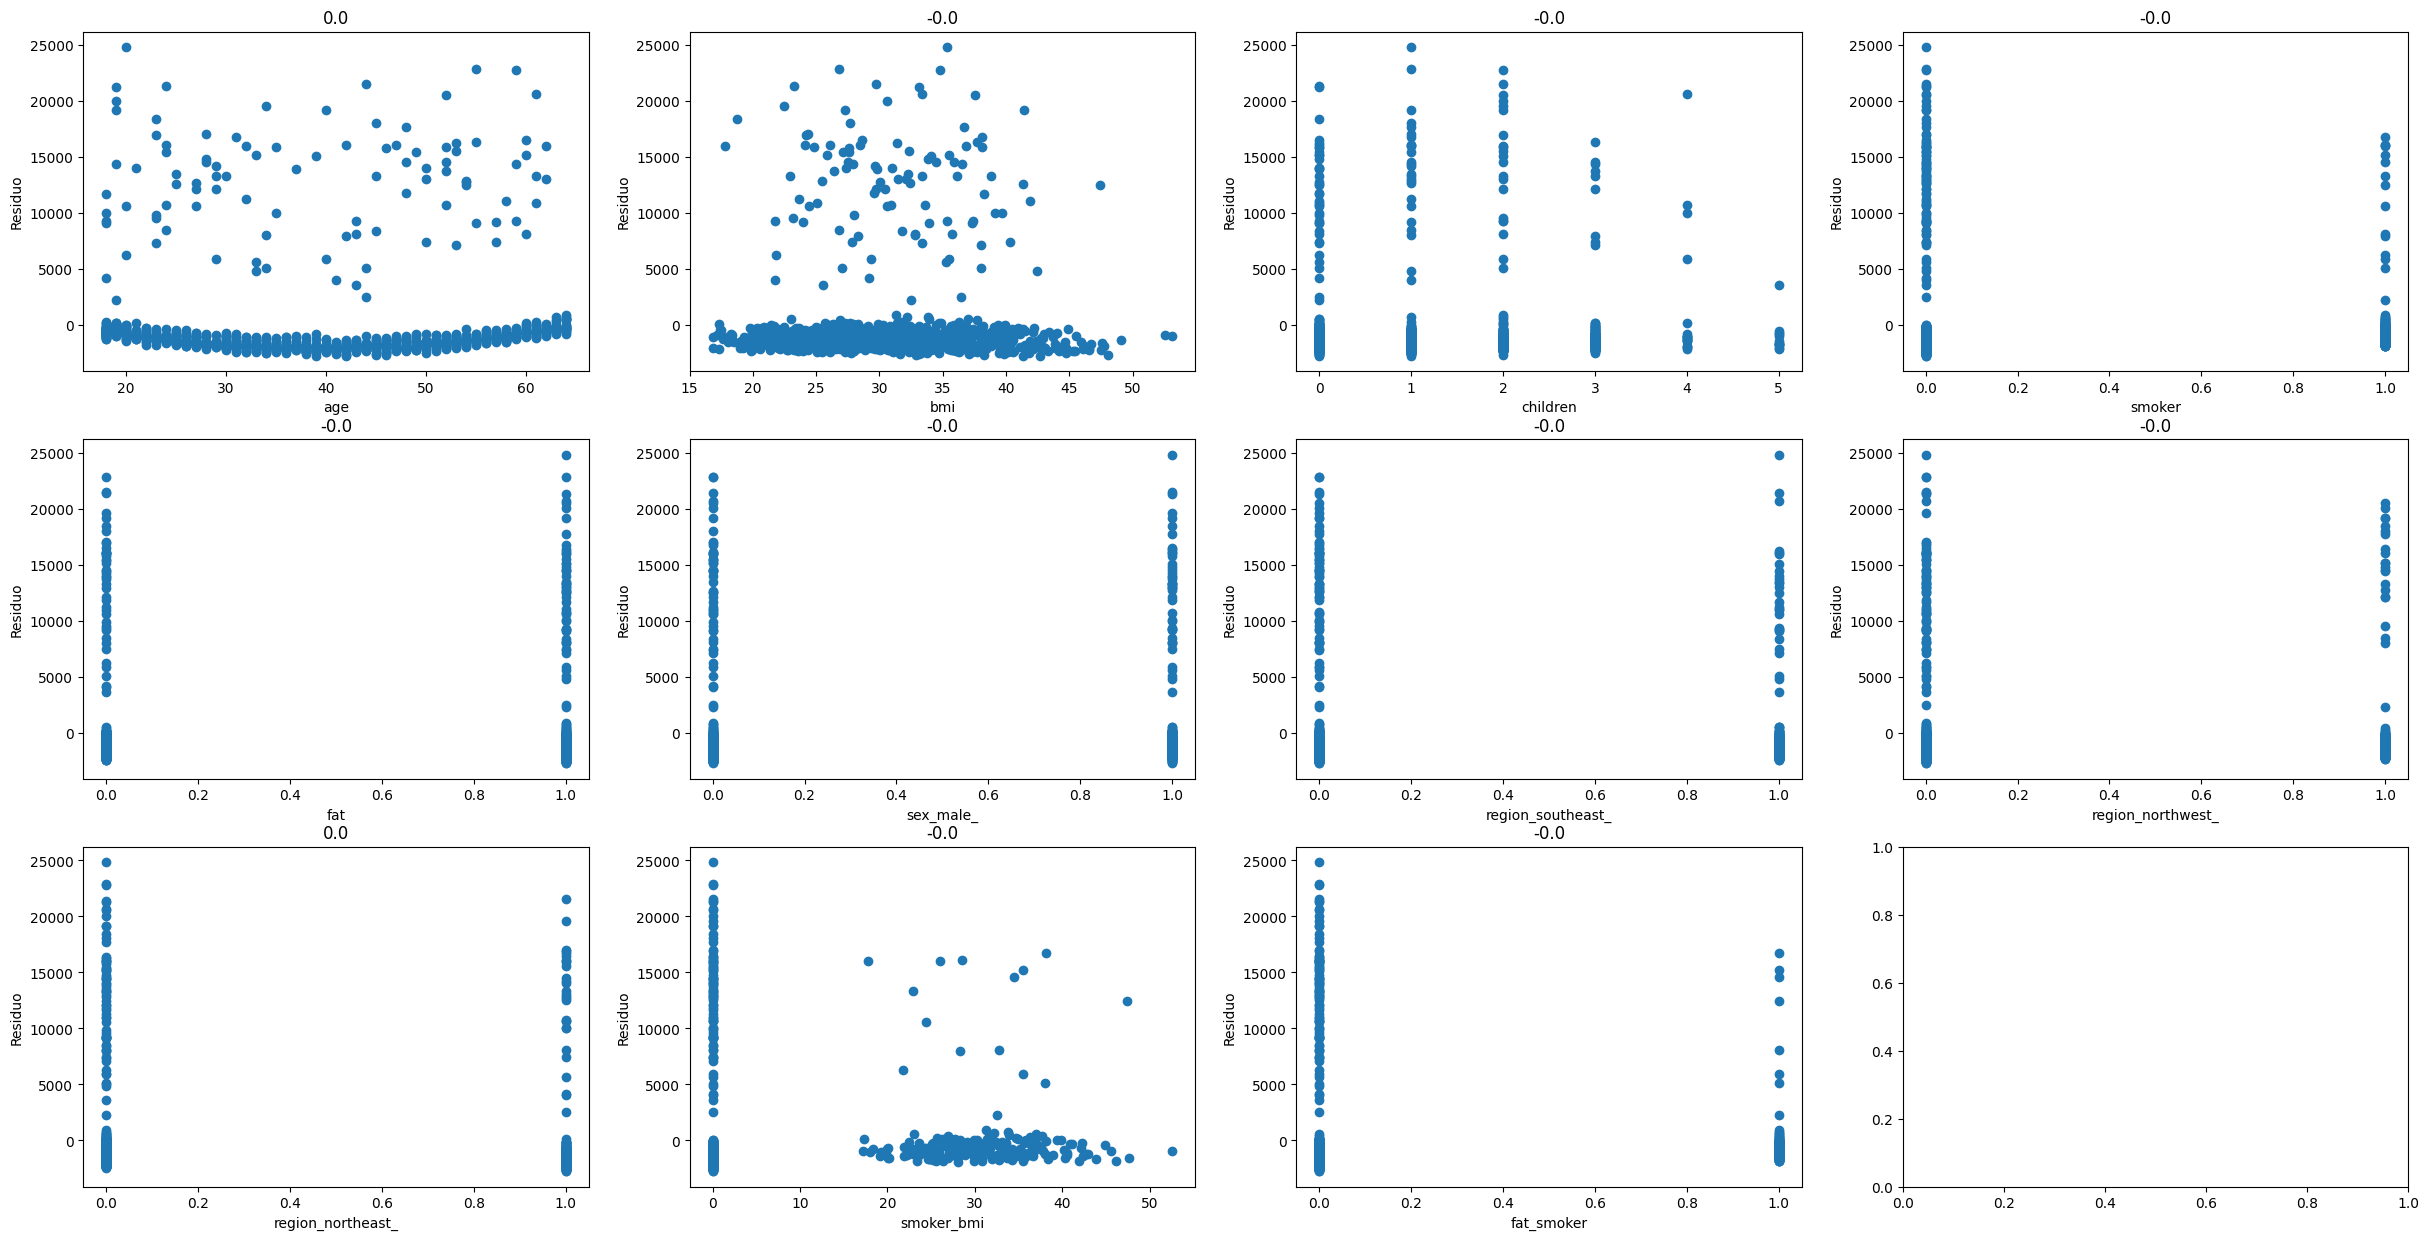

In [ ]:
# EXOGENEIDADE: premissa 3: RESIDUO NÃO TEM CORRELAÇÃO COM NENHUMA FEATURE -- almost OK
df_rl['residuo'] = res.resid

plt.close('all')
fig, axs = plt.subplots(3, 4, figsize=(30, 15))
for i, col in enumerate(features):
    idy = i//4
    idx = i%4

    corr = round(df_rl[[col, 'residuo']].corr()['residuo'].values[0], 3)

    axs[idy][idx].scatter(x=df_rl[col], y=df_rl['residuo'])
    axs[idy][idx].set_title(corr)
    axs[idy][idx].set_xlabel(col)
    axs[idy][idx].set_ylabel('Residuo')

print('pearson correlation between residue and...')
plt.show()
## OK

corr: 0.026071973607153315


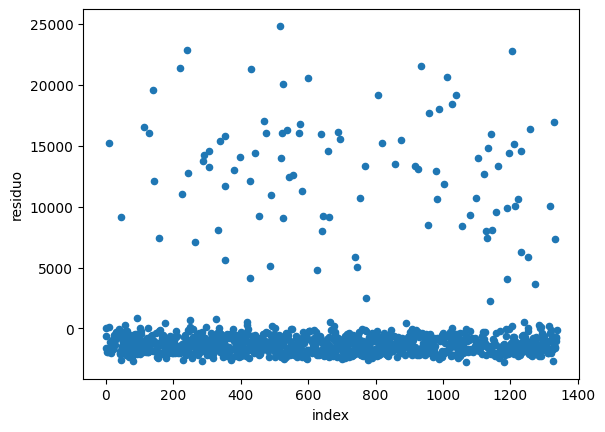

In [154]:
# premissa 4: AUSENCIA DE AUTO CORRELAÇÃO NOS RESIDOS -- OK
print('corr:', df_rl[['residuo']].reset_index().corr().values[0, 1])
df_rl[['residuo']].reset_index().plot.scatter(x='index', y='residuo'); 

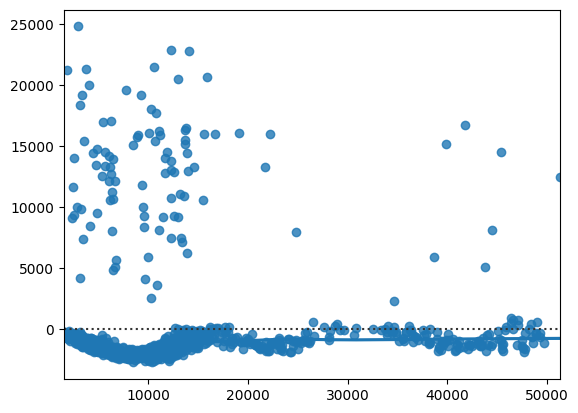

In [ ]:
# HOMOCEDASTICIDADE: premissa 5: CONSTANCIA NA VARIAÇÃO DOS RESIDUOS NA DIREÇÃO DO TARGET PREVISTO -- almost OK
sns.residplot(x=res.fittedvalues, y=res.resid, lowess=True);

,Feature,VIF
0,age,7.424990
1,bmi,8.072580
2,children,1.791335
3,smoker_bmi,1.260432


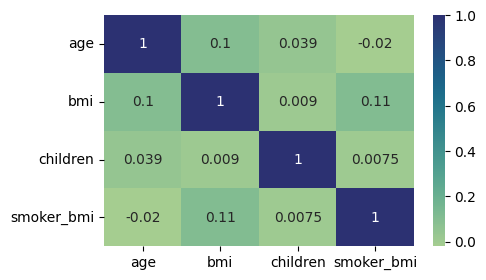

In [156]:
# premissa 6: AUSENSIA DE MULTICOLINEARIDIADE -- OK
# removida features com VIF >= 10 e corr com outras features >= |.75|
features_continuas = [col for col in features if not len([dummie for dummie in dummies if dummie in col])] + boosted_no_dummie_features

display(
    pd.DataFrame({
        'Feature': df_rl[features_continuas].columns,
        'VIF': [variance_inflation_factor(df_rl[features_continuas].values, i_col) for i_col in range(len(df_rl[features_continuas].columns))]
    })
)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.heatmap(df_rl[features_continuas].corr(), cmap='crest', annot=True, ax=ax)
plt.show()

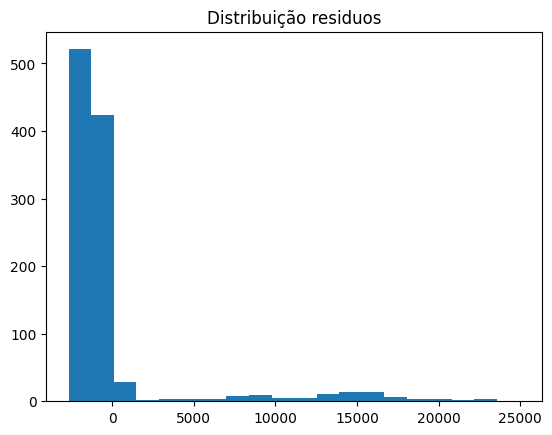

In [142]:
# premissa 7 (extra): RESIDUOS SEGUEM DISTRIBUIÇÃO NORMAL -- NOT OK

fig, ax = plt.subplots(1, 1)

ax.hist(res.resid, bins=20)
ax.set_title('Distribuição residuos')

plt.show()